In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from core.classifiers.fc_net import *
from core.data_utils import get_CIFAR10_data
from core.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from core.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


## Batch normalization: Forward

In [8]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print 'Before batch normalization:'
print '  means: ', a.mean(axis=0)
print '  stds: ', a.std(axis=0)

# Means should be close to zero and stds close to one
print 'After batch normalization (gamma=1, beta=0)'
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print '  mean: ', a_norm.mean(axis=0)
print '  std: ', a_norm.std(axis=0)

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
bn_param = {'mode': 'train'}
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)
print 'After batch normalization (nontrivial gamma, beta)'
print '  means: ', a_norm.mean(axis=0)
print '  stds: ', a_norm.std(axis=0)

Before batch normalization:
  means:  [ 4.48103315 -3.38643227 -9.33013516]
  stds:  [ 31.51212633  33.89553759  29.93636409]
After batch normalization (gamma=1, beta=0)
  mean:  [  7.46624984e-17  -2.74780199e-17  -1.88737914e-16]
  std:  [ 0.99999999  1.          0.99999999]
After batch normalization (nontrivial gamma, beta)
  means:  [ 11.  12.  13.]
  stds:  [ 0.99999999  1.99999999  2.99999998]


In [12]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in xrange(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means close to zero and stds close to one, but
# noisier than training-time forward passes.
print 'After batch normalization (test-time):'
print '  means: ', a_norm.mean(axis=0)
print '  stds: ', a_norm.std(axis=0)

After batch normalization (test-time):
  means:  [-0.00888429  0.03900028 -0.07721629]
  stds:  [ 0.99373225  1.02741029  0.99889777]


## Batch Normalization: backward

In [14]:
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print 'dx error: ', rel_error(dx_num, dx)
print 'dgamma error: ', rel_error(da_num, dgamma)
print 'dbeta error: ', rel_error(db_num, dbeta)

dx error:  9.87710127599e-09
dgamma error:  7.13578701735e-12
dbeta error:  9.6705350472e-12


## Fully Connected Nets with Batch Normalization
Add batch normalization layer to the fully connected net

In [17]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print 'Running check with reg = ', reg
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            use_batchnorm=True)

  loss, grads = model.loss(X, y)
  print 'Initial loss: ', loss

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))
  if reg == 0: print

Running check with reg =  0
Initial loss:  2.34535135358
W1 relative error: 4.55e-05
W2 relative error: 7.71e-05
W3 relative error: 5.73e-10
b1 relative error: 1.11e-08
b2 relative error: 2.22e-08
b3 relative error: 1.79e-10
beta1 relative error: 2.67e-09
beta2 relative error: 5.23e-08
gamma1 relative error: 2.73e-09
gamma2 relative error: 1.02e-07

Running check with reg =  3.14
Initial loss:  7.0824856724
W1 relative error: 4.54e-06
W2 relative error: 1.21e-05
W3 relative error: 1.06e-08
b1 relative error: 4.44e-03
b2 relative error: 5.55e-09
b3 relative error: 1.54e-10
beta1 relative error: 5.14e-08
beta2 relative error: 1.05e-08
gamma1 relative error: 1.26e-07
gamma2 relative error: 7.60e-09


# Batchnorm for deep networks
Train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [18]:
# training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

(Iteration 1 / 200) loss: 2.301683
(Epoch 0 / 10) train acc: 0.115000; val_acc: 0.112000
(Epoch 1 / 10) train acc: 0.341000; val_acc: 0.245000
(Epoch 2 / 10) train acc: 0.424000; val_acc: 0.305000
(Epoch 3 / 10) train acc: 0.501000; val_acc: 0.339000
(Epoch 4 / 10) train acc: 0.591000; val_acc: 0.344000
(Epoch 5 / 10) train acc: 0.611000; val_acc: 0.327000
(Epoch 6 / 10) train acc: 0.676000; val_acc: 0.328000
(Epoch 7 / 10) train acc: 0.721000; val_acc: 0.321000
(Epoch 8 / 10) train acc: 0.754000; val_acc: 0.322000
(Epoch 9 / 10) train acc: 0.792000; val_acc: 0.325000
(Epoch 10 / 10) train acc: 0.794000; val_acc: 0.316000
(Iteration 1 / 200) loss: 2.302715
(Epoch 0 / 10) train acc: 0.134000; val_acc: 0.119000
(Epoch 1 / 10) train acc: 0.252000; val_acc: 0.231000
(Epoch 2 / 10) train acc: 0.292000; val_acc: 0.260000
(Epoch 3 / 10) train acc: 0.332000; val_acc: 0.285000
(Epoch 4 / 10) train acc: 0.321000; val_acc: 0.291000
(Epoch 5 / 10) train acc: 0.416000; val_acc: 0.298000
(Epoch 6 / 

Visualize the results from two networks trained above. Batch normalization helps the network to converge much faster.

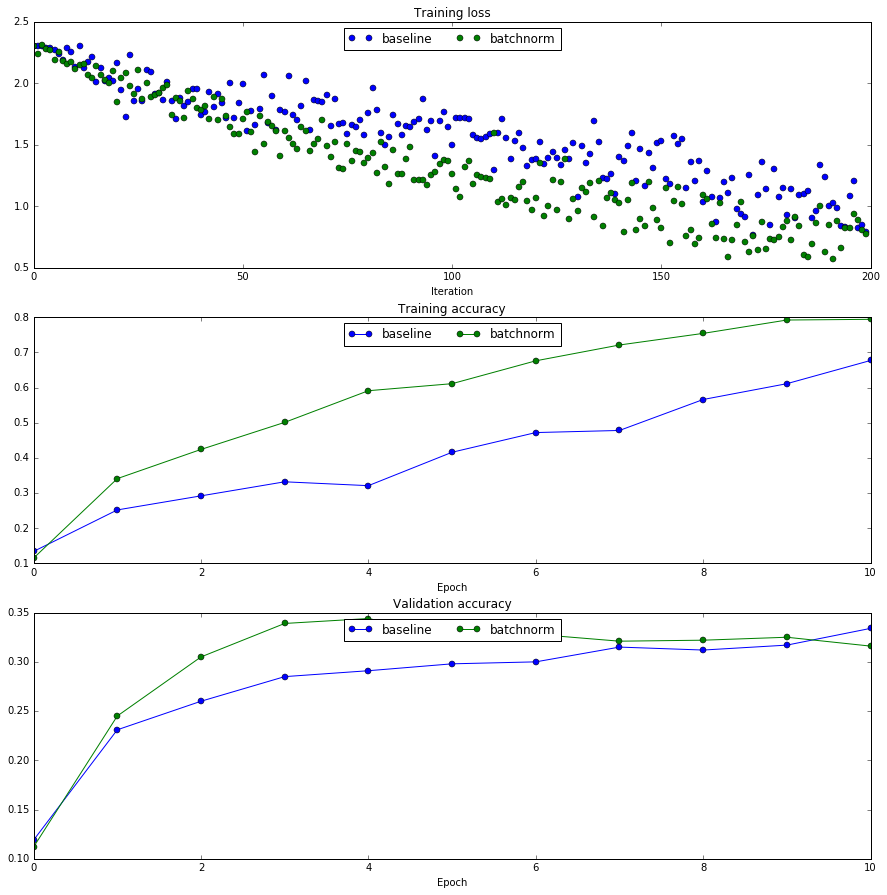

In [19]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o', label='baseline')
plt.plot(bn_solver.loss_history, 'o', label='batchnorm')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')
plt.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
plt.plot(bn_solver.val_acc_history, '-o', label='batchnorm')
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch normalization and initialization
Run experiment to study the interaction of batch normalization and weight initialization.

The first cell will train 8-layer networks both with and without batch normalization using different scales for weight initialization. The second layer will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

In [20]:
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
  print 'Running weight scale %d / %d' % (i + 1, len(weight_scales))
  bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
  model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

  bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  bn_solver.train()
  bn_solvers[weight_scale] = bn_solver

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  solver.train()
  solvers[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


core/layers.py:561: RuntimeWarning: divide by zero encountered in log
  Returns a tuple of:


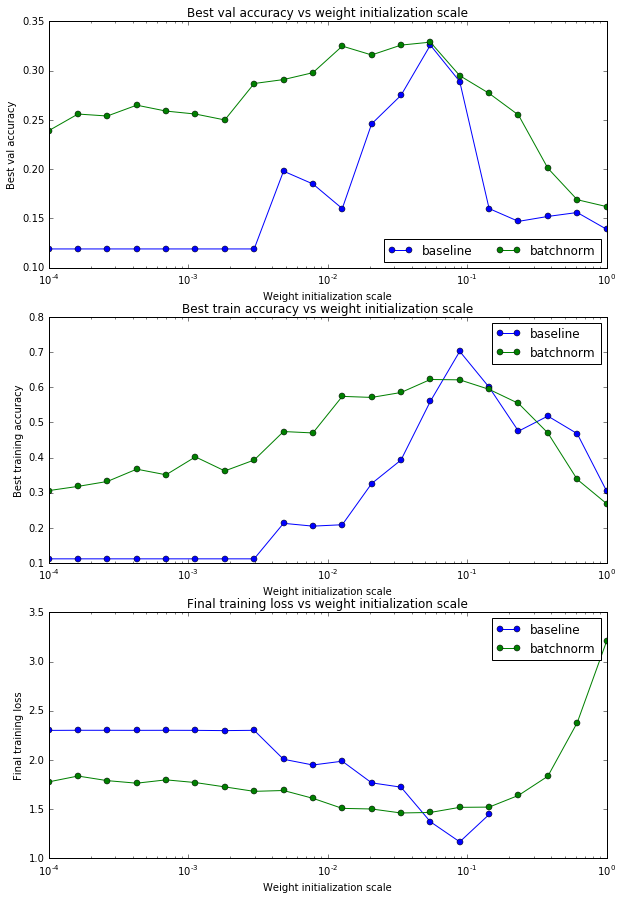

In [21]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))
  
  best_val_accs.append(max(solvers[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()